In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time_lib
import random

from tqdm import tqdm

import multiprocessing

from scripts.dynamics import vecField
from scripts.plotting import plot_results
from scripts.ode_solvers import solver
from scripts.parareal import parallel_solver

In [2]:
np.random.seed(17)
random.seed(17)

number_iterates = 100
number_processors = 1

avg_cost = 0.
avg_coarse_steps = 0.

for _ in tqdm(range(number_iterates)):
    
    system = "Lorenz"
    nodes = "legendrePoints"
    n_x = 5

    LB = -1.
    UB = 1.
    L = 5

    vecRef = vecField(system=system)

    if system=="Rober":
            k1,k2,k3 = vecRef.k1,vecRef.k2,vecRef.k3
            t_max = 100.
            num_t = 101
            L = 3
            n_t = 2
            vecRef.dt_fine = 1e-4
    elif system=="SIR":
            beta,gamma,N = vecRef.beta,vecRef.gamma,vecRef.N
            t_max = 100.
            num_t = 101
            L = 3
            n_t = 2
            vecRef.dt_fine = 1e-2
    elif system=="Brusselator":
            A,B = vecRef.A,vecRef.B 
            t_max = 12.
            num_t = 32
            L = 5
            n_t = 2
            vecRef.dt_fine = t_max/640
    elif system=="Arenstorf":
            a,b = vecRef.a,vecRef.b 
            t_max = 17#.0652165601579625588917206249 #One period
            num_t = 125
            n_x = 5
            L = 3
            n_t = 2
            vecRef.dt_fine = t_max / 80000
    elif system=="Lorenz":
            sigma,r,b = vecRef.sigma,vecRef.r,vecRef.b
            t_max = 10.
            num_t = 51
            L = 3
            n_t = 5
            vecRef.dt_fine = t_max / 14400
    elif system=="Burger":
            L = 5
            nu = vecRef.nu
            dx = vecRef.dx
            x = vecRef.x
            t_max = 1.
            num_t = 51
            n_t = 2
            vecRef.dt_fine = t_max / 100
    else:
            print("Dynamics not implemented")

    weight = np.random.uniform(low=LB,high=UB,size=(L))
    bias = np.random.uniform(low=LB,high=UB,size=(L))
        
    time = np.linspace(0,t_max,num_t)
    dts = np.diff(time)

    if system=="Rober":
            y0 = np.array([1.,0.,0])
    elif system=="SIR":
            y0 = np.array([0.3,0.5,0.2])
    elif system=="Brusselator":
            y0 = np.array([0.,1.])
    elif system=="Arenstorf":
            y0 = np.array([0.994,0,0.,-2.00158510637908252240537862224])
    elif system=="Lorenz":
            y0 = np.array([20.,5,-5])
    elif system=="Burger":
            #y0 = np.sin(2*np.pi*vecRef.x)
            y0 = np.sin(2*np.pi*vecRef.x) + np.cos(4*np.pi*vecRef.x) - np.cos(8*np.pi*vecRef.x) 
            #y0 = vecRef.x*(1.-vecRef.x)
    else:
            print("Dynamics not implemented")
    
    data = {"LB" : LB,
        "UB" : UB,
        "L" : L,
        "y0" : y0,
        "weight" : weight,
        "bias" : bias,
        "n_x" : n_x,
        "n_t" : n_t,
        "system" : system,
        "nodes" : nodes,
        "act_name" : "tanh"}

    #num_processors_list = [1]
    #computational_times = []
    #overheads = []
    #used_processors = []
    #for number_processors in num_processors_list:
    #    print(f"Experiment with {number_processors} processors")
    coarse_approx,networks,total_time,number_processors,avg_coarse_step = parallel_solver(time,data,dts,vecRef,number_processors,verbose=False)
    #used_processors.append(number_processors)
    #overheads.append(overhead_costs)
    #computational_times.append(total_time)
    avg_cost += total_time
    avg_coarse_steps += avg_coarse_step
avg_cost /= number_iterates
avg_coarse_steps /= number_iterates
print("\n\n")
print(f"The average cost over {number_iterates} of the hybrid parareal is {avg_cost}")
print(f"The average cost of one coarse step over {number_iterates} of the hybrid parareal is {avg_coarse_steps}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:29<00:00,  3.30s/it]




The average cost over 100 of the hybrid parareal is 3.2982769417762756
The average cost of one coarse step over 100 of the hybrid parareal is 0.0051980403900146474


In [3]:
'''if len(num_processors_list)>1:
    fig = plt.figure(dpi=600)
    plt.plot(num_processors_list,computational_times,'ko')
    plt.xlabel("Number of processors")
    plt.ylabel("Computational time")
    plt.savefig(f"savedPlots/comparison_costVSprocessors_{system}.pdf")
    
    for i in range(len(num_processors_list)):
        plt.plot(num_processors_list[i],overheads[i],'r-o')
    plt.title("Overhead costs")
    plt.xlabel("Number processors")
    plt.ylabel("Cost")'''

'if len(num_processors_list)>1:\n    fig = plt.figure(dpi=600)\n    plt.plot(num_processors_list,computational_times,\'ko\')\n    plt.xlabel("Number of processors")\n    plt.ylabel("Computational time")\n    plt.savefig(f"savedPlots/comparison_costVSprocessors_{system}.pdf")\n    \n    for i in range(len(num_processors_list)):\n        plt.plot(num_processors_list[i],overheads[i],\'r-o\')\n    plt.title("Overhead costs")\n    plt.xlabel("Number processors")\n    plt.ylabel("Cost")'

In [4]:
def get_detailed_solution():
    num_steps = int((networks[0].dt / vecRef.dt_fine))
    print(num_steps)
    time_plot = np.linspace(0,networks[0].dt,num_steps+1)
    sol = networks[0].plotOverTimeRange(time_plot)
    total_time = time_plot
    for i in np.arange(1,len(networks)):
        num_steps = int((networks[i].dt / vecRef.dt_fine))
        time_plot = np.linspace(0,networks[i].dt,num_steps+1)[1:]
        sol = np.concatenate((sol,networks[i].plotOverTimeRange(time_plot)),axis=1)
        total_time = np.concatenate((total_time,time_plot+total_time[-1]),axis=0)
    return sol,total_time

In [5]:
network_sol, time_plot = get_detailed_solution()

288


In [6]:
num_fine_steps_per_coarse = ( t_max / (num_t-1) ) / vecRef.dt_fine
num_fine_steps = t_max / vecRef.dt_fine

In [7]:
initial = time_lib.time()
arg = [[y0,time_plot[-1],time_plot],vecRef]
output,time_plot_sequential = solver(arg,final=False)
final = time_lib.time()
print(f"Computational time sequential: {final-initial}")
print(f"Computational time parallel with {number_processors} processors: {total_time}")
#print(f"Average cost one coarse step: {average_coarse_cost}")
print(f"Average cost fine steps to cover one coarse step: {total_time / num_fine_steps * num_fine_steps_per_coarse}")

Computational time sequential: 0.4836719036102295
Computational time parallel with 1 processors: 3.14695405960083
Average cost fine steps to cover one coarse step: 0.0629390811920166


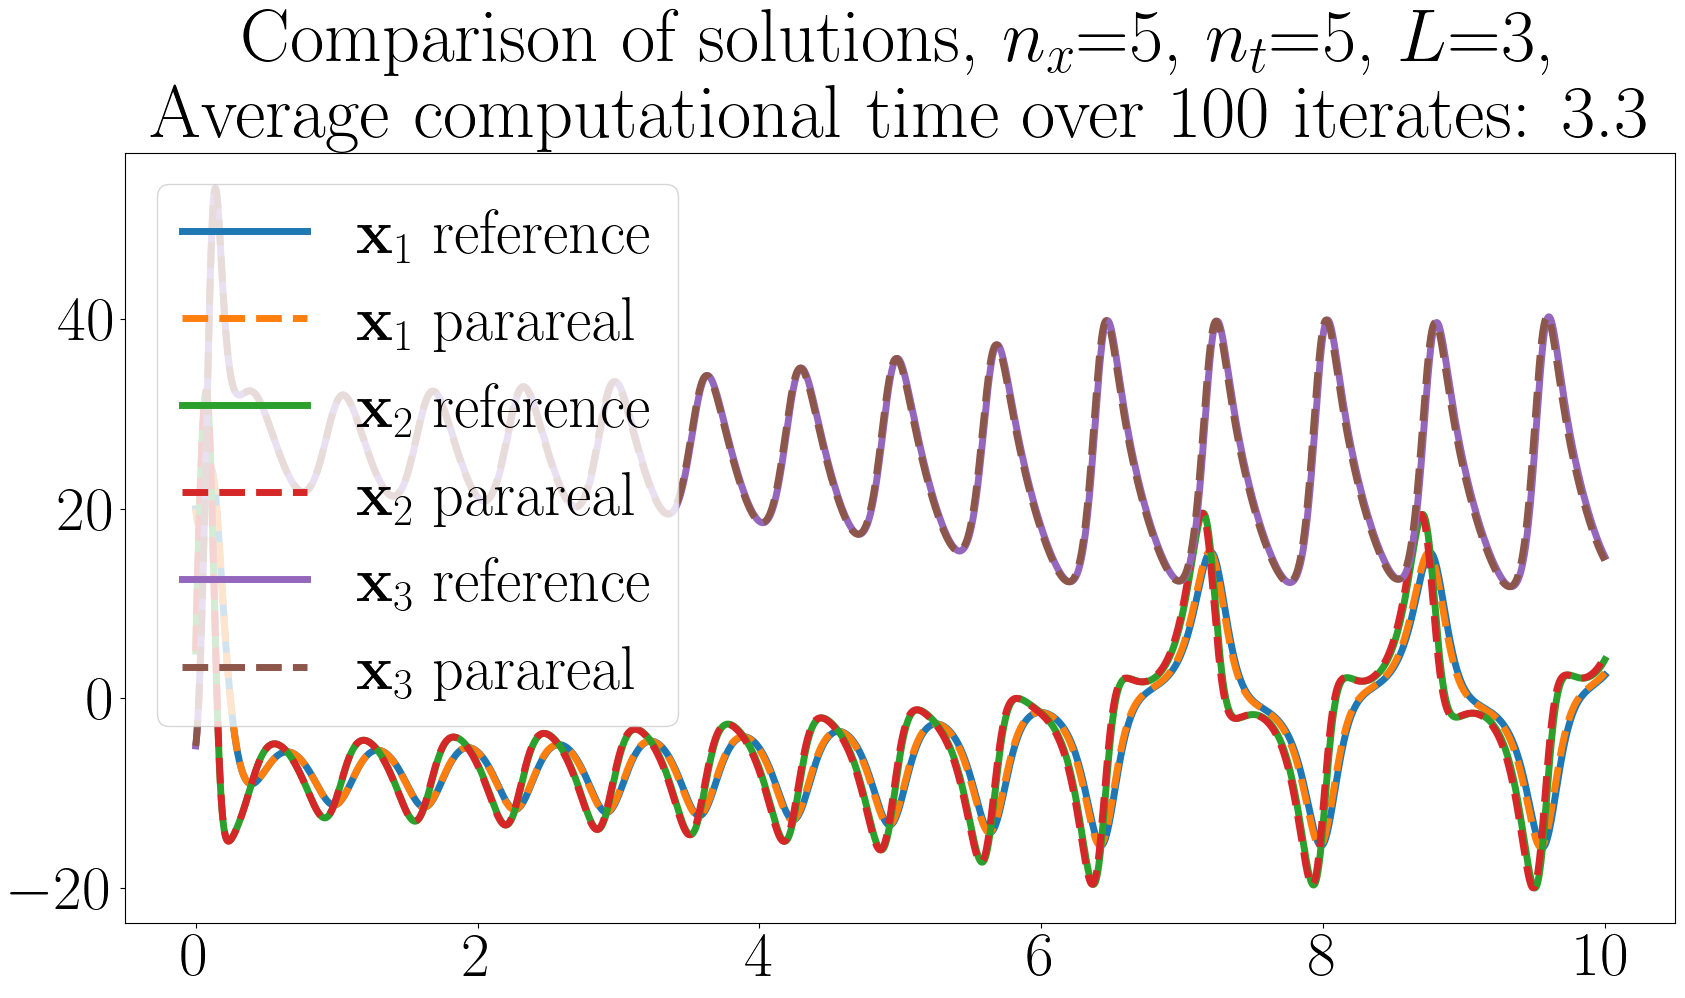

In [8]:
if len(y0)==2:
    list_of_labels = [r"$\mathbf{x}_1$",r"$\mathbf{x}_2$"]
elif len(y0)==3:
    list_of_labels = [r"$\mathbf{x}_1$",r"$\mathbf{x}_2$",r"$\mathbf{x}_3$"]
elif len(y0)==4:
    list_of_labels = [r"$\mathbf{x}_1$",r"$\\mathbf{x}_1'$",r"$\mathbf{x}_2$",r"$\mathbf{x}_2'$"]
else:
    list_of_labels = []
plot_results(y0,coarse_approx,networks,system,time_plot,time_plot_sequential,output,network_sol,list_of_labels,avg_cost,time,n_x,n_t,L,vecRef)

In [9]:
if system=="Burger":
    vec = vecRef

    for i in range(vec.N):
        fig = plt.figure()
        plt.plot(time_plot, output[:,i],'k-',label='true')
        plt.plot(time_plot, network_sol[i],'r--',label='pred')
        plt.xlabel("t")
        plt.ylabel(fr"$x_{i+1}$")
        plt.xticks(np.linspace(0,1,11))
        plt.legend()
        plt.show();